# DCT example
taken from https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.fftpack
from skimage import data, io, filters


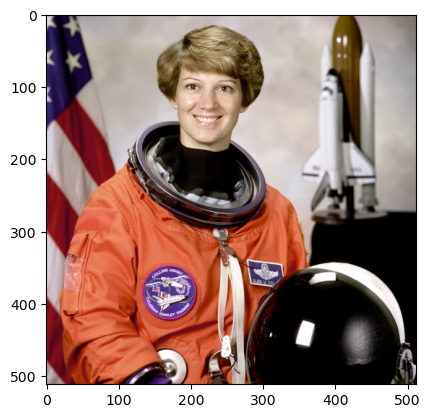

In [21]:
im = data.astronaut()
plt.imshow(im)


In [3]:

def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')



In [83]:
# Do 8x8 DCT on image (in-place)
n = 8
dct = np.zeros(im.shape)
for i in np.r_[:im.shape[0]:n]:
    for j in np.r_[:im.shape[1]:n]:
        dct[i:(i+n),j:(j+n)] = dct2( im[i:(i+n),j:(j+n)] )

In [87]:
np.array(im.shape) // 8

array([37, 48])

In [ ]:
np.array(im.shape) // 8

ValueError: cannot reshape array of size 116352 into shape (64,37,48)

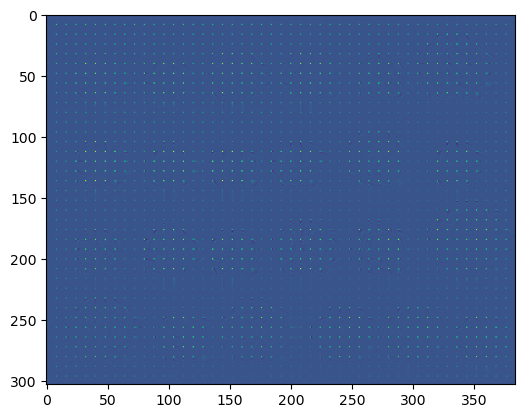

In [86]:
plt.imshow(dct)
dct.reshape((n*n,dct.shape[0]//n,dct.shape[1]//n))

In [92]:
M = np.zeros((3,3,5))
M[1,1] = 1
M

array([[[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]])

In [109]:
n = 10
stride = 2
block_size = 4
print((n - block_size) / stride)
np.arange(0,n - block_size, stride)
np.r_[:n - block_size: stride]


3.0


array([0, 2, 4])

In [122]:
im[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1)].shape
block_size*j

384

In [145]:
for i in np.arange(dct.shape[0]):
    print(i,stride*i,stride*i+block_size)

0 0 8
1 2 10
2 4 12
3 6 14
4 8 16
5 10 18
6 12 20
7 14 22
8 16 24
9 18 26
10 20 28
11 22 30
12 24 32
13 26 34
14 28 36
15 30 38
16 32 40
17 34 42
18 36 44
19 38 46
20 40 48
21 42 50
22 44 52
23 46 54
24 48 56
25 50 58
26 52 60
27 54 62
28 56 64
29 58 66
30 60 68
31 62 70
32 64 72
33 66 74
34 68 76
35 70 78
36 72 80
37 74 82
38 76 84
39 78 86
40 80 88
41 82 90
42 84 92
43 86 94
44 88 96
45 90 98
46 92 100
47 94 102
48 96 104
49 98 106
50 100 108
51 102 110
52 104 112
53 106 114
54 108 116
55 110 118
56 112 120
57 114 122
58 116 124
59 118 126
60 120 128
61 122 130
62 124 132
63 126 134


In [32]:
im.shape.T

AttributeError: 'tuple' object has no attribute 'T'

In [36]:
def dct2D(im, out_channels, block_size, stride):
    shape = (im.shape[0]*block_size*block_size, *((np.array(im.shape[1:])-block_size) // stride))
    print(shape)
    dst = np.zeros(shape)
    for c in im.shape[0]:
        for i in np.arange(dst.shape[1]):    
            for j in np.arange(dst.shape[2]):
                block = im[c, stride*i:stride*i+block_size, stride*j:stride*j+block_size]
                for a in range(2):
                    block = scipy.fftpack.dct(block, axis = a, norm='ortho')
                    dst[c*block_size*block_size:(c+1)*block_size*block_size,:,:] = block.ravel()
#            dst[:,i,j] = dct2( im[stride*i:stride*i+block_size, stride*j:stride*j+block_size] ).ravel()
    return dst


stride = 2
block_size = 8
plt.imshow(dct2D(im.T,8,4)[1])

TypeError: dct2D() missing 1 required positional argument: 'stride'

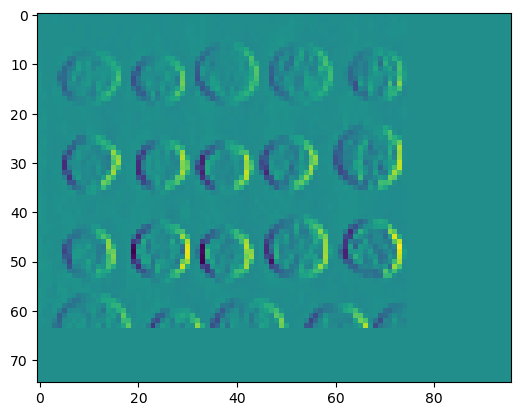

In [135]:
plt.imshow(dct[1])


In [51]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
km.fit(Y)
labels = km.labels_.reshape(im.shape)


/home/jeromeb/miniconda3/envs/imaging/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


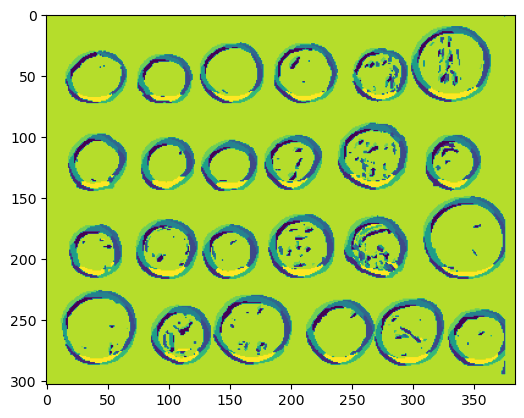

In [52]:
plt.imshow(labels)